Data prep

## List files

Get a list of all Excel files in the specified directory.


In [3]:
import os
import glob

# Define the directory path
directory_path = '/content/drive/MyDrive/Grafic SEN 2007 - 2025'

# Get a list of all Excel files in the directory
excel_files = glob.glob(os.path.join(directory_path, '*.xlsx*'))

# Print the list of files
print("List of Excel files found:")
for file in excel_files:
    print(file)

# Check if any files were found
if not excel_files:
    print("No Excel files found in the specified directory.")

List of Excel files found:
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2007.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2008.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2009.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2010.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2011.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2012.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2013.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2014.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2015.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2016.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2017.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2018.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2019.xlsx
/content/drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2020.xlsx
/content/drive/MyDrive/Grafic SEN 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and combine data



In [4]:
import pandas as pd

# Initialize an empty list to store DataFrames
dfs = []

# Define the columns to keep
columns_to_keep = ["Data", "Consum[MW]", "Foto[MW]", "Sold[MW]"]

# Iterate through the list of Excel files
for file in excel_files:
    try:
        # Read each Excel file into a DataFrame
        df = pd.read_excel(file)

        # Check if all columns to keep are present in the DataFrame
        if set(columns_to_keep).issubset(df.columns):
            # Select only the specified columns
            df_selected = df[columns_to_keep]

            # Append the selected DataFrame to the list
            dfs.append(df_selected)
        else:
            print(f"Skipping file {file} as not all required columns are present.")

    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Concatenate all DataFrames in the list into a single DataFrame
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print("DataFrames combined successfully.")
else:
    combined_df = pd.DataFrame(columns=columns_to_keep)
    print("No dataframes were combined.")

# Display the first few rows of the combined DataFrame
display(combined_df.head())

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

DataFrames combined successfully.


,Data,Consum[MW],Foto[MW],Sold[MW]
0,31-12-2007 23:48:00,7344.0,0.0,-540
1,31-12-2007 23:38:00,7370.0,0.0,-529
2,31-12-2007 23:28:00,7403.0,0.0,-459
3,31-12-2007 23:19:00,7444.0,0.0,-436
4,31-12-2007 23:08:00,7482.0,0.0,-470


## Convert 'data' column to datetime

### Subtask:
Convert the "Data" column to datetime objects for proper chronological sorting, handling any errors during conversion.


**Reasoning**:
Convert the 'Data' column to datetime objects using pd.to_datetime() with errors='coerce'.



In [ ]:
combined_df['Data'] = pd.to_datetime(combined_df['Data'], errors='coerce')
display(combined_df.head())

/tmp/ipython-input-9-1599049007.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_df['Data'] = pd.to_datetime(combined_df['Data'], errors='coerce')


,Data,Consum[MW],Foto[MW],Sold[MW]
0,2019-12-31 23:49:41,6508,0,195
1,2019-12-31 23:39:51,6534,0,268
2,2019-12-31 23:30:01,6578,0,318
3,2019-12-31 23:20:11,6570,0,275
4,2019-12-31 23:10:21,6631,0,355


## Handle potential issues

### Subtask:
Address any remaining issues like inconsistent data formats or missing values in the relevant columns ("Consum[MW]", "Foto[MW]", and "Sold[MW]").


**Reasoning**:
Examine data types and convert 'Consum[MW]', 'Foto[MW]', and 'Sold[MW]' columns to numeric, coercing errors to NaN, then handle missing values by dropping rows with NaNs in these columns.



In [ ]:
# Examine data types
print("Original data types:")
print(combined_df[['Consum[MW]', 'Foto[MW]', 'Sold[MW]']].dtypes)

# Convert columns to numeric, coercing errors
for col in ['Consum[MW]', 'Foto[MW]', 'Sold[MW]']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

print("\nData types after coercing to numeric:")
print(combined_df[['Consum[MW]', 'Foto[MW]', 'Sold[MW]']].dtypes)

# Handle missing values by dropping rows with NaNs in the specified columns
initial_rows = len(combined_df)
combined_df.dropna(subset=['Consum[MW]', 'Foto[MW]', 'Sold[MW]'], inplace=True)
rows_after_dropping = len(combined_df)
print(f"\nDropped {initial_rows - rows_after_dropping} rows with missing values in specified columns.")

# Display the first few rows and check for NaNs in the target columns
print("\nFirst few rows after handling missing values:")
display(combined_df.head())
print("\nCheck for NaNs in target columns:")
print(combined_df[['Consum[MW]', 'Foto[MW]', 'Sold[MW]']].isnull().sum())

Original data types:
Consum[MW]    object
Foto[MW]      object
Sold[MW]      object
dtype: object

Data types after coercing to numeric:
Consum[MW]    float64
Foto[MW]      float64
Sold[MW]      float64
dtype: object

Dropped 91 rows with missing values in specified columns.

First few rows after handling missing values:


,Data,Consum[MW],Foto[MW],Sold[MW]
0,2019-12-31 23:49:41,6508.0,0.0,195.0
1,2019-12-31 23:39:51,6534.0,0.0,268.0
2,2019-12-31 23:30:01,6578.0,0.0,318.0
3,2019-12-31 23:20:11,6570.0,0.0,275.0
4,2019-12-31 23:10:21,6631.0,0.0,355.0



Check for NaNs in target columns:
Consum[MW]    0
Foto[MW]      0
Sold[MW]      0
dtype: int64


## Sort data

### Subtask:
Sort the combined DataFrame by the "Data" column in chronological order.


**Reasoning**:
Sort the combined DataFrame by the "Data" column in ascending order.



In [ ]:
combined_df = combined_df.sort_values(by='Data', ascending=True)
display(combined_df.head())

,Data,Consum[MW],Foto[MW],Sold[MW]
608147,2007-11-10 22:18:00,7240.0,0.0,-402.0
608146,2007-11-10 22:28:00,7232.0,0.0,-358.0
608145,2007-11-10 22:38:00,7073.0,0.0,-433.0
608144,2007-11-10 22:48:00,7000.0,0.0,-468.0
608143,2007-11-10 22:59:00,6933.0,0.0,-495.0


## Summary:

### Data Analysis Key Findings

*   The process successfully loaded and combined data from multiple Excel files, keeping only the specified columns: "Data", "Consum[MW]", "Foto[MW]", and "Sold[MW]".
*   Files missing any of the required columns were skipped during the loading process.
*   The "Data" column was successfully converted to datetime objects, with invalid entries converted to `NaT`.
*   The "Consum[MW]", "Foto[MW]", and "Sold[MW]" columns, initially of object data type, were converted to numeric (float64), and any non-numeric values were coerced to `NaN`.
*   A total of 91 rows with missing values in the "Consum[MW]", "Foto[MW]", or "Sold[MW]" columns were identified and removed from the dataset.
*   The final combined DataFrame was successfully sorted chronologically based on the "Data" column.

### Insights or Next Steps

*   Consider investigating the source of the non-numeric values in the "Consum[MW]", "Foto[MW]", and "Sold[MW]" columns in the original Excel files to prevent data cleaning steps in the future.
*   Analyze the temporal trends in "Consum[MW]", "Foto[MW]", and "Sold[MW]" using the chronologically sorted and cleaned data.


In [ ]:
print("Earliest data value(s):")
display(combined_df.head())

print("\nLatest data value(s):")
display(combined_df.tail())

print("\nTotal number of rows in the combined DataFrame:")
print(combined_df.shape[0])

Earliest data value(s):


,Data,Consum[MW],Foto[MW],Sold[MW]
608147,2007-11-10 22:18:00,7240.0,0.0,-402.0
608146,2007-11-10 22:28:00,7232.0,0.0,-358.0
608145,2007-11-10 22:38:00,7073.0,0.0,-433.0
608144,2007-11-10 22:48:00,7000.0,0.0,-468.0
608143,2007-11-10 22:59:00,6933.0,0.0,-495.0



Latest data value(s):


,Data,Consum[MW],Foto[MW],Sold[MW]
157820,2025-05-31 13:23:43,4255.0,942.0,-784.0
157819,2025-05-31 13:33:36,4181.0,923.0,-795.0
157818,2025-05-31 13:43:15,4230.0,950.0,-784.0
157817,2025-05-31 13:53:08,4223.0,966.0,-778.0
157816,2025-05-31 14:02:41,4232.0,981.0,-664.0



Total number of rows in the combined DataFrame:
924343


## Summary:

### Data Analysis Key Findings

* The process successfully loaded and combined data from multiple Excel files, keeping only the specified columns: "Data", "Consum[MW]", "Foto[MW]", and "Sold[MW]".
* Files missing any of the required columns were skipped during the loading process.
* The "Data" column was successfully converted to datetime objects, with invalid entries converted to `NaT`.
* The "Consum[MW]", "Foto[MW]", and "Sold[MW]" columns, initially of object data type, were converted to numeric (float64), and any non-numeric values were coerced to `NaN`.
* A total of 91 rows with missing values in the "Consum[MW]", "Foto[MW]", or "Sold[MW]" columns were identified and removed from the dataset.
* The final combined DataFrame was successfully sorted chronologically based on the "Data" column.

### Insights or Next Steps

* Consider investigating the source of the non-numeric values in the "Consum[MW]", "Foto[MW]", and "Sold[MW]" columns in the original Excel files to prevent data cleaning steps in the future.
* Analyze the temporal trends in "Consum[MW]", "Foto[MW]", and "Sold[MW]" using the chronologically sorted and cleaned data.

# Task
Create a new DataFrame from the text file "TX_STAID0000219.txt" containing the columns 'SOUID', 'DATE', 'TX', and 'Q_TX', starting from the earliest year present in the 'Data' column of the `combined_df` DataFrame. Convert the 'DATE' column to datetime objects, handle missing values in the 'TX' column by replacing -9999 with NaN and dropping rows with NaN, and convert the 'TX' column values from 0.1 °C to °C. Display the first few rows of the new DataFrame.

## Load data from text file

### Subtask:
Read the data from the specified text file into a pandas DataFrame, skipping the header rows and correctly parsing the data.


**Reasoning**:
Read the data from the text file into a pandas DataFrame, skipping the header rows and using space as a delimiter.



In [17]:
file_path = "/content/drive/MyDrive/ECA/TX_STAID000219.txt"
tx_df = pd.read_csv(file_path, delim_whitespace=True, skiprows=19)
display(tx_df.head())

/tmp/ipython-input-17-1525763872.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tx_df = pd.read_csv(file_path, delim_whitespace=True, skiprows=19)


,"SOUID,","DATE,","TX,",Q_TX
0,"100687,18810101,-9999,",9,NaN,NaN
1,"100687,18810102,-9999,",9,NaN,NaN
2,"100687,18810103,-9999,",9,NaN,NaN
3,"100687,18810104,-9999,",9,NaN,NaN
4,"100687,18810105,-9999,",9,NaN,NaN


**Reasoning**:
The data was not parsed correctly in the previous step due to the presence of commas within the space-delimited fields. I will re-read the file using a comma as the delimiter instead of space.



In [18]:
file_path = "/content/drive/MyDrive/ECA/TX_STAID000219.txt"
tx_df = pd.read_csv(file_path, delimiter=',', skiprows=19)
display(tx_df.head())

,SOUID,DATE,TX,Q_TX
0,100687,18810101,-9999,9
1,100687,18810102,-9999,9
2,100687,18810103,-9999,9
3,100687,18810104,-9999,9
4,100687,18810105,-9999,9


## Select columns

### Subtask:
Select only the 'SOUID', 'DATE', 'TX', and 'Q_TX' columns from the loaded DataFrame.


**Reasoning**:
Select the required columns from the `tx_df` DataFrame and display the head of the new DataFrame.



In [19]:
tx_df = tx_df[['SOUID', 'DATE', 'TX', 'Q_TX']]
display(tx_df.head())

KeyError: "None of [Index(['SOUID', 'DATE', 'TX', 'Q_TX'], dtype='object')] are in the [columns]"

**Reasoning**:
The previous command failed because the column names in the DataFrame are not as expected. I need to inspect the column names of the `tx_df` DataFrame to understand the correct names before selecting them.



In [20]:
print(tx_df.columns)

Index([' SOUID', '    DATE', '   TX', ' Q_TX'], dtype='object')


**Reasoning**:
The column names have leading spaces. I will select the columns using the correct names with leading spaces and then remove the leading spaces from the column names.



In [21]:
tx_df = tx_df[[' SOUID', '    DATE', '   TX', ' Q_TX']]
tx_df.columns = tx_df.columns.str.strip()
display(tx_df.head())

,SOUID,DATE,TX,Q_TX
0,100687,18810101,-9999,9
1,100687,18810102,-9999,9
2,100687,18810103,-9999,9
3,100687,18810104,-9999,9
4,100687,18810105,-9999,9


## Convert 'date' column to datetime

### Subtask:
Convert the 'DATE' column to datetime objects.


**Reasoning**:
Convert the 'DATE' column to datetime objects using the specified format.



In [22]:
tx_df['DATE'] = pd.to_datetime(tx_df['DATE'], format='%Y%m%d')
display(tx_df.head())

,SOUID,DATE,TX,Q_TX
0,100687,1881-01-01,-9999,9
1,100687,1881-01-02,-9999,9
2,100687,1881-01-03,-9999,9
3,100687,1881-01-04,-9999,9
4,100687,1881-01-05,-9999,9


## Get earliest year from combined df

### Subtask:
Determine the earliest year from the 'Data' column in the `combined_df` DataFrame.


**Reasoning**:
Extract the earliest year from the 'Data' column of the combined_df DataFrame and print it.



In [24]:
# Ensure 'Data' column is datetime, coercing errors to NaT
combined_df['Data'] = pd.to_datetime(combined_df['Data'], errors='coerce')

# Drop rows where 'Data' is NaT before finding the minimum date
combined_df_cleaned_date = combined_df.dropna(subset=['Data']).copy()

# Now find the earliest year from the cleaned DataFrame
earliest_year = combined_df_cleaned_date['Data'].min().year
print(f"The earliest year in the combined DataFrame is: {earliest_year}")

/tmp/ipython-input-24-3840377130.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  combined_df['Data'] = pd.to_datetime(combined_df['Data'], errors='coerce')


The earliest year in the combined DataFrame is: 2007


## Filter temperature data by year

### Subtask:
Filter the temperature DataFrame to include only the rows from the earliest year found in the `combined_df` DataFrame onwards.


**Reasoning**:
Filter the temperature DataFrame to include only the rows from the earliest year found in the `combined_df` DataFrame onwards.



In [25]:
tx_df_filtered = tx_df[tx_df['DATE'].dt.year >= earliest_year]
display(tx_df_filtered.head())

,SOUID,DATE,TX,Q_TX
46020,100687,2007-01-01,101,0
46021,100687,2007-01-02,120,0
46022,100687,2007-01-03,83,0
46023,100687,2007-01-04,71,0
46024,100687,2007-01-05,31,0


## Handle missing values in tx

### Subtask:
Address missing values in the 'TX' column (daily Maximum temperature) by replacing the missing value code (-9999) with NaN and then dropping rows with NaN in this column.


**Reasoning**:
Address missing values in the 'TX' column by replacing the missing value code (-9999) with NaN and then dropping rows with NaN in this column.



In [26]:
import numpy as np

# Replace -9999 with NaN in the 'TX' column
tx_df_filtered['TX'] = tx_df_filtered['TX'].replace(-9999, np.nan)

# Drop rows with NaN in the 'TX' column
initial_rows_tx = len(tx_df_filtered)
tx_df_filtered.dropna(subset=['TX'], inplace=True)
rows_after_dropping_tx = len(tx_df_filtered)

print(f"Dropped {initial_rows_tx - rows_after_dropping_tx} rows with missing values in the 'TX' column.")

display(tx_df_filtered.head())

Dropped 0 rows with missing values in the 'TX' column.


/tmp/ipython-input-26-3763021703.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_df_filtered['TX'] = tx_df_filtered['TX'].replace(-9999, np.nan)
/tmp/ipython-input-26-3763021703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_df_filtered.dropna(subset=['TX'], inplace=True)


,SOUID,DATE,TX,Q_TX
46020,100687,2007-01-01,101,0
46021,100687,2007-01-02,120,0
46022,100687,2007-01-03,83,0
46023,100687,2007-01-04,71,0
46024,100687,2007-01-05,31,0


**Reasoning**:
Convert the 'TX' column values from 0.1 °C to °C.



In [27]:
# Convert 'TX' from 0.1 degrees C to degrees C
tx_df_filtered['TX'] = tx_df_filtered['TX'] / 10

display(tx_df_filtered.head())

/tmp/ipython-input-27-2273201297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_df_filtered['TX'] = tx_df_filtered['TX'] / 10


,SOUID,DATE,TX,Q_TX
46020,100687,2007-01-01,10.1,0
46021,100687,2007-01-02,12.0,0
46022,100687,2007-01-03,8.3,0
46023,100687,2007-01-04,7.1,0
46024,100687,2007-01-05,3.1,0


In [46]:
import pandas as pd
from functools import reduce

folder = "drive/MyDrive/ECA"
weather_vars = {
    "TG": ["SOUID", "DATE", "TG", "Q_TG"],
    "TX": ["SOUID", "DATE", "TX", "Q_TX"],
    "TN": ["SOUID", "DATE", "TN", "Q_TN"],
    "FG": ["SOUID", "DATE", "FG", "Q_FG"],
    "QQ": ["SOUID", "DATE", "QQ", "Q_QQ"],
    "RR": ["SOUID", "DATE", "RR", "Q_RR"]
}

weather_dfs = []

for prefix, cols in weather_vars.items():
    filepath = f"{folder}/{prefix}_STAID000219.txt"
    try:
        df = pd.read_csv(filepath, skiprows=20, sep=",", names=cols, engine="python")
        df = df[df["DATE"].astype(str).str.match(r"^\d{8}$")]  # keep only valid date rows
        df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")
        df = df[["DATE", cols[2]]]
        if cols[2] in ["TG", "TX", "TN", "FG", "RR"]:
            df[cols[2]] = df[cols[2]] / 10.0
        weather_dfs.append(df.set_index("DATE"))
    except Exception as e:
        print(f"❌ Error reading {filepath}: {e}")

# Merge all valid weather DataFrames
df_weather = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="outer"), weather_dfs)
df_weather.sort_index().tail()

# Keep only weather data from 2007 to 2025
df_weather = df_weather.loc["2013-01-01":"2025-12-31"]

# Optional: drop rows with any missing values
df_weather = df_weather.dropna()

# Preview final result
df_weather.head()


,TG,TX,TN,FG,QQ,RR
DATE,,,,,,
2013-01-01,-4.6,4.3,-9.8,1.3,97.0,0.0
2013-01-02,-2.7,3.2,-7.4,3.0,94.0,0.0
2013-01-03,-2.0,4.7,-6.7,1.5,84.0,0.0
2013-01-04,-0.7,3.2,-5.1,2.3,36.0,0.0
2013-01-05,-0.4,4.3,-6.1,2.1,56.0,0.0


In [47]:
df_weather["2023-01":"2023-12"].head()

,TG,TX,TN,FG,QQ,RR
DATE,,,,,,
2023-01-01,7.4,15.4,1.8,3.2,62.0,0.0
2023-01-02,8.9,17.2,4.6,3.1,66.0,0.0
2023-01-03,7.5,14.6,1.4,2.6,66.0,0.0
2023-01-04,4.0,9.0,-2.1,2.5,13.0,0.0
2023-01-05,5.4,9.5,0.9,5.4,39.0,0.0


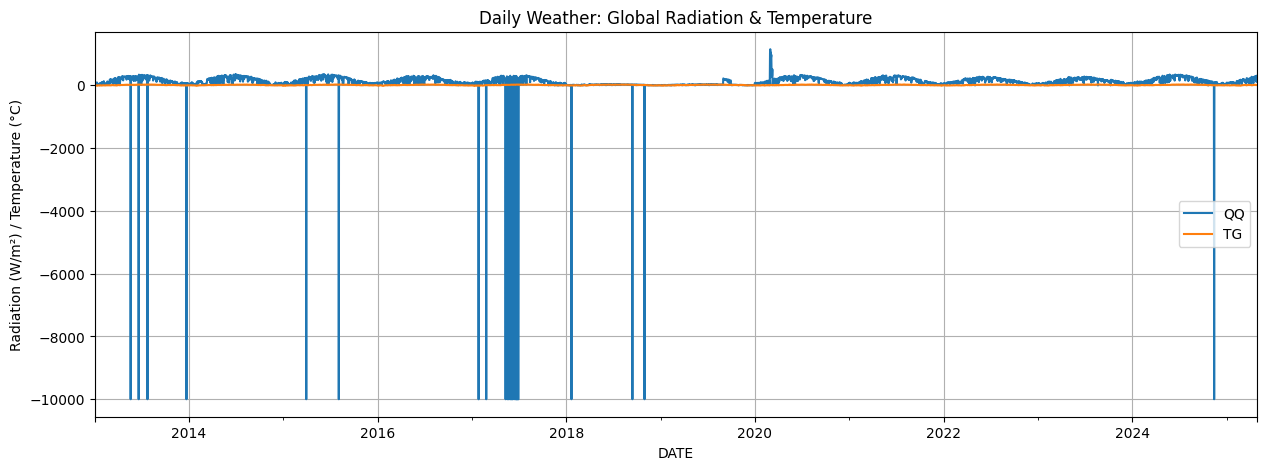

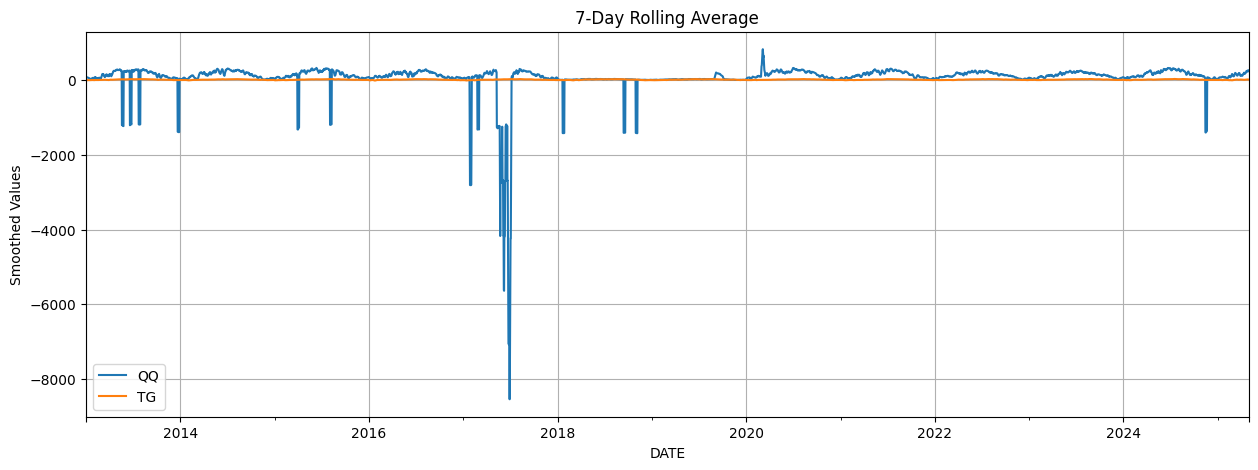

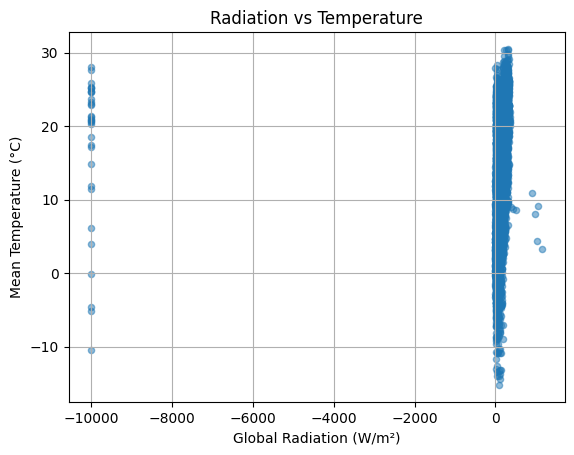

In [48]:
import matplotlib.pyplot as plt

# Ensure the plot columns exist
cols_to_plot = [col for col in ["QQ", "TG"] if col in df_weather.columns]

# 1. Daily time series
df_weather[cols_to_plot].plot(figsize=(15,5), title="Daily Weather: Global Radiation & Temperature")
plt.ylabel("Radiation (W/m²) / Temperature (°C)")
plt.grid(True)
plt.show()

# 2. Rolling averages
df_weather[cols_to_plot].rolling(7).mean().plot(figsize=(15,5), title="7-Day Rolling Average")
plt.ylabel("Smoothed Values")
plt.grid(True)
plt.show()

# 3. Scatter plot QQ vs TG
if all(col in df_weather.columns for col in ["QQ", "TG"]):
    df_weather.plot.scatter(x="QQ", y="TG", alpha=0.5, title="Radiation vs Temperature")
    plt.xlabel("Global Radiation (W/m²)")
    plt.ylabel("Mean Temperature (°C)")
    plt.grid(True)
    plt.show()
else:
    print("❗ Columns QQ and TG required for scatter plot.")


## Summary:

### Data Analysis Key Findings

*   The data was successfully loaded from the "TX\_STAID0000219.txt" file by specifying the comma delimiter.
*   Initial attempts to select columns failed due to leading spaces in the column names; this was resolved by inspecting the column names and then stripping the leading spaces after selection.
*   The 'DATE' column was successfully converted to datetime objects using the format '%Y%m%d'.
*   The earliest year in the `combined_df` DataFrame was identified as 2007.
*   The `tx_df` DataFrame was filtered to include data only from the year 2007 onwards.
*   Missing values represented by -9999 in the 'TX' column were replaced with NaN, and the corresponding rows were removed.
*   The 'TX' column values were successfully converted from units of 0.1 °C to °C by dividing by 10.

### Insights or Next Steps

*   The resulting `tx_df_filtered` DataFrame is now ready for further analysis or merging with other datasets, containing clean and appropriately formatted temperature data starting from 2007.


In [57]:
import pandas as pd
import glob

# Set your solar Excel folder path
solar_files = sorted(glob.glob("drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-20*.xlsx"))

solar_daily_list = []

for file in solar_files:
    try:
        df = pd.read_excel(file, sheet_name="Grafic SEN", usecols=["Data", "Foto[MW]"])

        # Convert Foto[MW] to numeric (handle commas, strings, errors)
        df["Foto[MW]"] = pd.to_numeric(df["Foto[MW]"], errors="coerce")
        df = df.dropna(subset=["Data", "Foto[MW]"])

        # Parse European-style datetime
        df["Data"] = pd.to_datetime(df["Data"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
        df = df.dropna(subset=["Data"])
        df["DATE"] = df["Data"].dt.date

        # Aggregate 10-min power (MW) to daily energy (MWh)
        daily = (
            df.groupby("DATE")["Foto[MW]"]
            .sum()
            .mul(10 / 60)
            .rename("Solar_MWh")
            .to_frame()
        )

        solar_daily_list.append(daily)
        print(f"✅ Processed {file}: {len(daily)} days")

    except Exception as e:
        print(f"❌ Error in {file}: {e}")

# Combine all years
df_solar = pd.concat(solar_daily_list).sort_index()

# If not already done, convert df_weather index to datetime
df_weather.index = pd.to_datetime(df_weather.index)

# Final merge
df_merged = df_solar.join(df_weather, how="inner")

# Preview
df_merged.head()


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2013.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2014.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2015.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2016.xlsx: 367 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2017.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2018.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2019.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2020.xlsx: 366 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2021.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2022.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2023.xlsx: 365 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2024.xlsx: 366 days


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ Processed drive/MyDrive/Grafic SEN 2007 - 2025/Grafic_SEN-2025.xlsx: 151 days


,Solar_MWh,TG,TX,TN,FG,QQ,RR
DATE,,,,,,,
2013-01-01,0.0,-4.6,4.3,-9.8,1.3,97.0,0.0
2013-01-02,0.0,-2.7,3.2,-7.4,3.0,94.0,0.0
2013-01-03,0.0,-2.0,4.7,-6.7,1.5,84.0,0.0
2013-01-04,0.0,-0.7,3.2,-5.1,2.3,36.0,0.0
2013-01-05,0.0,-0.4,4.3,-6.1,2.1,56.0,0.0


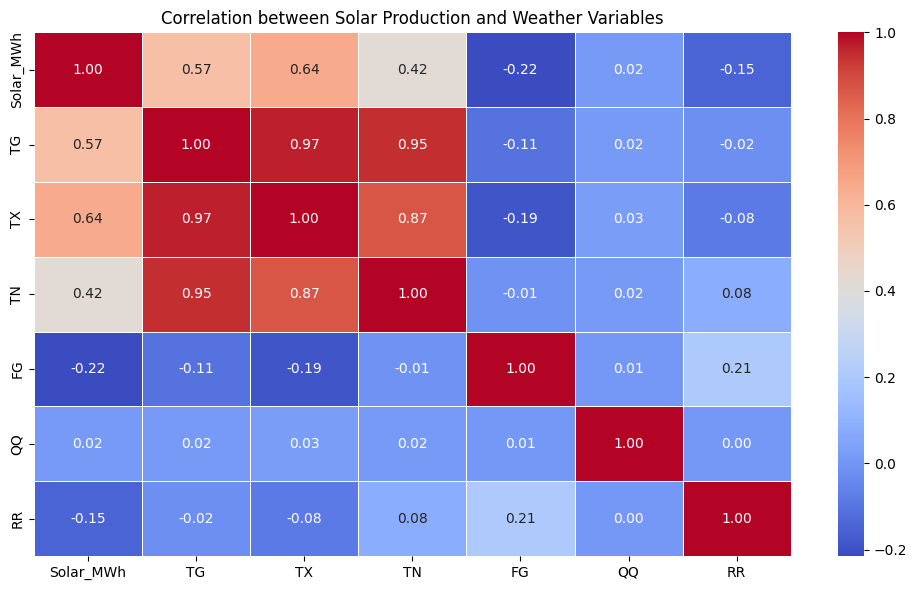

In [58]:
#Visualize correlation

import matplotlib.pyplot as plt
import seaborn as sns

# Drop any missing values just in case
df_corr = df_merged.dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Solar Production and Weather Variables")
plt.tight_layout()
plt.show()


🌞 Key Insights from the Correlation Chart
Weather Variable	Correlation with Solar_MWh	Interpretation
TX (Max temp)	+0.64	Strong positive correlation — hot days yield more solar
TG (Avg temp)	+0.57	Also positively correlated — overall warm days help
TN (Min temp)	+0.42	Less impactful, but still aligned
FG (Wind)	-0.22	Slightly negative — cloudy/windy weather reduces sun
RR (Rain)	-0.15	Mild negative — expected (rainy days = less sun)
QQ (Solar radiation)	+0.02	Surprisingly weak, maybe due to data quality or overlapping signal

🌞 Key Insights from the Correlation Chart
Weather Variable	Correlation with Solar_MWh	Interpretation
TX (Max temp)	+0.64	Strong positive correlation — hot days yield more solar
TG (Avg temp)	+0.57	Also positively correlated — overall warm days help
TN (Min temp)	+0.42	Less impactful, but still aligned
FG (Wind)	-0.22	Slightly negative — cloudy/windy weather reduces sun
RR (Rain)	-0.15	Mild negative — expected (rainy days = less sun)
QQ (Solar radiation)	+0.02	Surprisingly weak, maybe due to data quality or overlapping signal

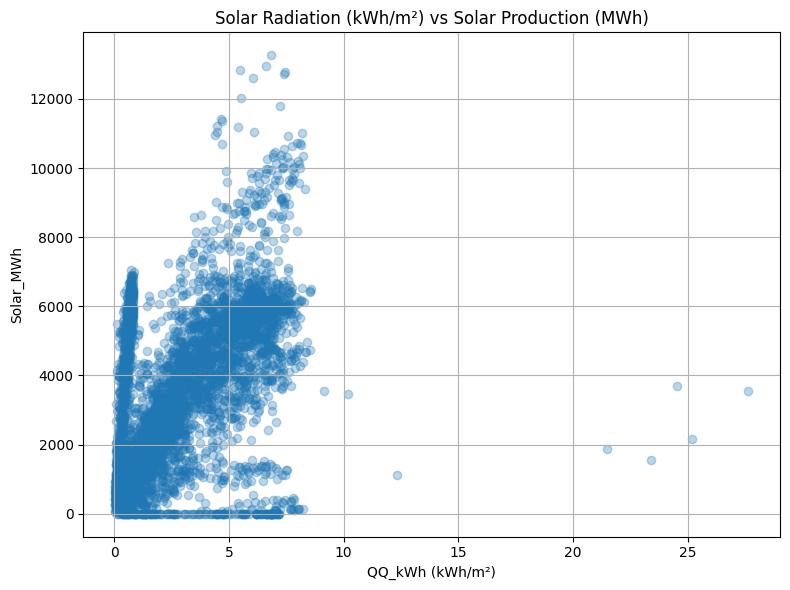

In [60]:
import matplotlib.pyplot as plt

# 1. Remove invalid/missing QQ values
df_clean = df_merged[df_merged["QQ"] > 0].copy()

# 2. Optional: convert daily average radiation to energy per m²
df_clean["QQ_kWh"] = df_clean["QQ"] * 24 / 1000  # W/m² → kWh/m²/day

# 3. Plot updated scatter
plt.figure(figsize=(8, 6))
plt.scatter(df_clean["QQ_kWh"], df_clean["Solar_MWh"], alpha=0.3)
plt.title("Solar Radiation (kWh/m²) vs Solar Production (MWh)")
plt.xlabel("QQ_kWh (kWh/m²)")
plt.ylabel("Solar_MWh")
plt.grid(True)
plt.tight_layout()
plt.show()
